In [92]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
import random

matplotlib.style.use('ggplot')
%matplotlib inline

In [93]:
# Describe the Data
df = pd.read_csv("fer2013.csv")
print(df.head())
print("Number of unique Emotions: %s" % (df.emotion.unique()))

   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training
Number of unique Emotions: [0 2 4 6 3 5 1]


In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
emotion    35887 non-null int64
pixels     35887 non-null object
Usage      35887 non-null object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [95]:
# Helper Functions
# pixels is the series from the Dataframe
def extract_from_string(pixels):
    pixels = pixels.split(' ')
    pixels = np.array([int(i) for i in pixels])
    return np.reshape(pixels, (48, 48))    

def extract_image(pixels):
    pixels = pixels.as_matrix()[0] # The output is a string
    return extract_from_string(pixels)  

In [87]:
# Overview of the images
def overview(total_rows, df):
    fig = plt.figure(figsize=(8,10))
    idx = 0
    for i, row in df.iterrows():
        input_img = extract_from_string(row.pixels)
        ax = fig.add_subplot(16,12,idx+1)
        ax.imshow(input_img, cmap=matplotlib.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
        idx += 1
    plt.show()

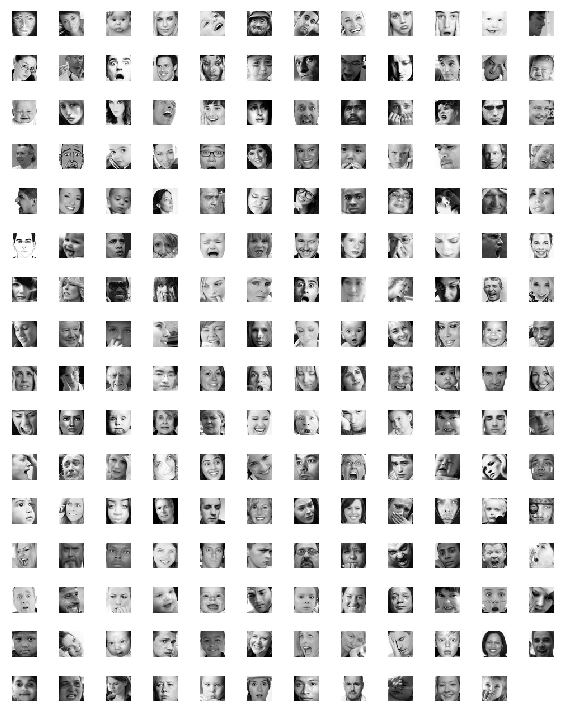

In [88]:
num_images = 191
df = df.sample(n=num_images)
overview(num_images, df) # overview of face data as thumbnails (private)

C:\DalbirData\New folder\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


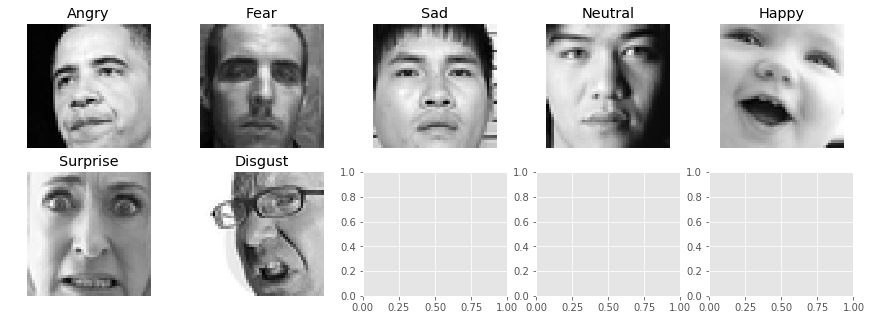

In [96]:
# Display one unique Emotion
emotion_description = {0:"Angry", 1:"Disgust", 2:"Fear", 3:"Happy", 4:"Sad", 5:"Surprise", 6:"Neutral"}

unique_emotions = df.emotion.unique()
images = []
emotions = []
for emotion in unique_emotions:
    emotion_df = df[df.emotion == emotion].sample(n=1)
    images.append(extract_image(emotion_df.pixels))
    emotions.append(emotion)

cols = 5
fig, ax = plt.subplots(len(images) // cols + 1, cols, figsize=(15, 5))
global_img = None
for i,img in enumerate(images):
    row = i // cols
    col = i % cols
    ax[row, col].imshow(img, cmap='gray')
    ax[row, col].axis('off')
    ax[row, col].set_title(emotion_description[emotions[i]])
    global_img = img

0    4953
1     547
2    5121
3    8989
4    6077
5    4002
6    6198
Name: emotion, dtype: int64


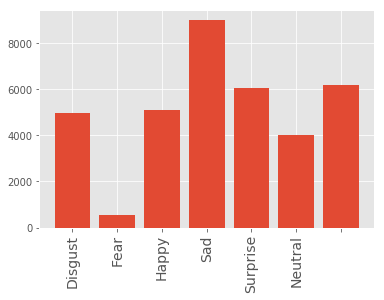

In [97]:
# Data Distribution
value_counts = df['emotion'].value_counts().sort_index()
ax = plt.subplot()
x_ticks_labels = [emotion_description[i] for i in range(len(value_counts))]
ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=14)
ax.bar(range(0, len(value_counts)), value_counts)
print(value_counts)

In [98]:
# Use Image Augmentation to Augment the dataset
from scipy import ndimage
from scipy.misc import imresize
from skimage import data, io, filters
from skimage.transform import swirl

import cv2

In [99]:
# Image Augmentation Techniques
def display_side_by_side(img1, img2):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img1, cmap='gray')
    ax[0].axis('off')
    ax[1].imshow(img2, cmap='gray')
    ax[1].axis('off')

In [100]:
def ogrid(img):
    nimg = np.copy(img)
    lx, ly = nimg.shape
    X, Y = np.ogrid[0:lx, 0:ly]
    mask = (X - lx / 2) ** 2 + (Y - ly / 2) ** 2 > lx * ly / 4
    nimg[mask] = 0
    return nimg

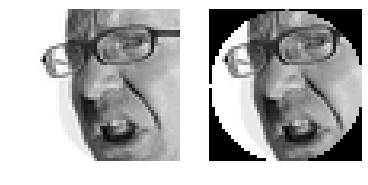

In [101]:
nimg = ogrid(global_img)
display_side_by_side(global_img, nimg)

In [102]:
def rotate_img(img):
    angle = np.random.choice(np.random.uniform(-45,45,100))
    nimg = np.copy(img)
    nimg = ndimage.rotate(nimg, angle)
    height, width = img.shape
    nimg = imresize(nimg, (width, height))
    return nimg

C:\DalbirData\New folder\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  


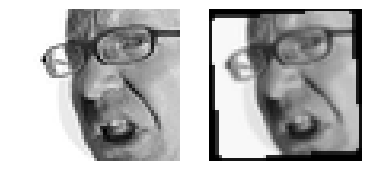

In [103]:
nimg = rotate_img(global_img)
display_side_by_side(global_img, nimg)

In [104]:
def blur_img(img):
    nimg = np.copy(img)
    sigma = np.random.randint(1, 2)
    blurred_img = ndimage.gaussian_filter(nimg, sigma=sigma)
    return blurred_img

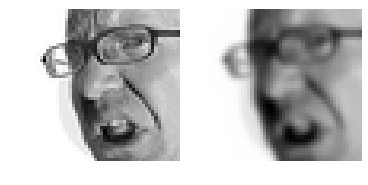

In [105]:
nimg = blur_img(global_img)
display_side_by_side(global_img, nimg)

In [106]:
def flip_img(img):
    nimg = np.copy(img)
    nimg = np.fliplr(nimg)
    return nimg

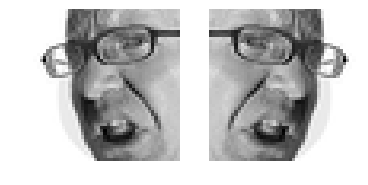

In [107]:
nimg = flip_img(global_img)
display_side_by_side(global_img, nimg)

In [108]:
def add_noise(img):
    nimg = np.copy(img)
    noise = np.random.normal(0,0.5,size=(48, 48)).astype(np.uint8) * 255
    nimg += noise
    nimg = np.clip(nimg, 0, 255)
    return nimg

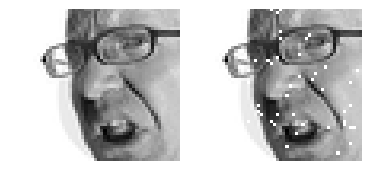

In [109]:
nimg = add_noise(global_img)
display_side_by_side(global_img, nimg)

In [110]:
def augment_img(img):
    methods = [ogrid, rotate_img, blur_img, flip_img, add_noise]

    method = np.random.choice(methods)
    return method(img)

In [111]:
max_value = df['emotion'].value_counts().max()
max_idx = df['emotion'].value_counts().idxmax()
print(max_idx, max_value)

3 8989


In [112]:
# Convert the pixels from the Dataframe into actual images
new_df = pd.DataFrame()
for i, row in df.iterrows():
    # Take this row and convert its pixel type to actual image
    new_df = new_df.append(pd.Series([row.emotion, extract_from_string(row.pixels), row.Usage], index=['emotion', 'pixels', 'Usage'], name=str(i)))
    
print(new_df)

             Usage  emotion                                             pixels
0         Training      0.0  [[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, ...
1         Training      0.0  [[151, 150, 147, 155, 148, 133, 111, 140, 170,...
2         Training      2.0  [[231, 212, 156, 164, 174, 138, 161, 173, 182,...
3         Training      4.0  [[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, ...
4         Training      6.0  [[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 2...
5         Training      2.0  [[55, 55, 55, 55, 55, 54, 60, 68, 54, 85, 151,...
6         Training      4.0  [[20, 17, 19, 21, 25, 38, 42, 42, 46, 54, 56, ...
7         Training      3.0  [[77, 78, 79, 79, 78, 75, 60, 55, 47, 48, 58, ...
8         Training      3.0  [[85, 84, 90, 121, 101, 102, 133, 153, 153, 16...
9         Training      2.0  [[255, 254, 255, 254, 254, 179, 122, 107, 95, ...
10        Training      0.0  [[30, 24, 21, 23, 25, 25, 49, 67, 84, 103, 120...
11        Training      6.0  [[39, 75, 78, 58, 58, 4

In [113]:
# Make all the Image categories the same size
augmented_df = new_df.copy()
unique_emotions = new_df.emotion.unique()
for emotion in unique_emotions:
    if emotion != max_idx:
        # This is the dataset we want to augment
        # Find the current length of this emotion
        emotion_df = augmented_df[augmented_df.emotion == emotion]
        current_size = len(emotion_df)
        images_2_generate = max_value - current_size
        for i in range(0, images_2_generate):
            # Choose a random image
            emotion_df = augmented_df[augmented_df.emotion == emotion].sample(n=1)
            current_img = emotion_df.pixels[0]
            nimg = augment_img(current_img)
            
            # Add a new row
            row = pd.Series([emotion, nimg, "Training"], index=["emotion", "pixels", "Usage"], name=str(i))
            augmented_df = augmented_df.append(row)

C:\DalbirData\New folder\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  


0.0    8989
1.0    8989
2.0    8989
3.0    8989
4.0    8989
5.0    8989
6.0    8989
Name: emotion, dtype: int64


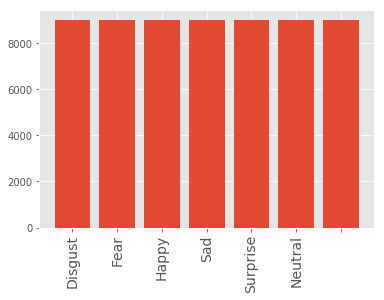

In [114]:
# New Data Distribution
value_counts = augmented_df['emotion'].value_counts().sort_index()
ax = plt.subplot()
x_ticks_labels = [emotion_description[i] for i in range(len(value_counts))]
ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=14)
ax.bar(range(0, len(value_counts)), value_counts)
print(value_counts)

In [115]:
# Network
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Lambda, Activation
from keras.layers import Conv2D, MaxPooling2D, concatenate, Input
from keras.callbacks import TensorBoard
from keras.models import load_model, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras_tqdm import TQDMNotebookCallback

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [116]:
class LeNet:
    @staticmethod
    def build(width, height, depth, classes, weightsPath=None):
        model = Sequential()
        # First set Conv Layers
        model.add(Conv2D(64, (3, 3), padding='valid', input_shape=(width, height, depth), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(BatchNormalization())

        # 2nd set Conv layers
        model.add(Conv2D(128, (3, 3), padding='valid', input_shape=(width, height, depth), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(BatchNormalization())

        model.add(Conv2D(256, (3, 3), padding='valid', activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(BatchNormalization())

        model.add(Conv2D(512, (3, 3), padding='valid', activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # Set of FC => Relu layers
        model.add(Flatten())
        model.add(Dense(256))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))

        # Softmax classifier
        model.add(Dense(classes))
        model.add(Activation('softmax'))

        if weightsPath is not None:
            model.load_weights(weightsPath)

        return model

In [117]:
model = LeNet.build(48, 48, 1, 7)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
generator = ImageDataGenerator( featurewise_center=True,
                            samplewise_center=False,
                            featurewise_std_normalization=False,
                            samplewise_std_normalization=False,
                            zca_whitening=False,
                            rotation_range=20.,
                            width_shift_range=0.4,
                            height_shift_range=0.4,
                            shear_range=0.2,
                            zoom_range=0.2,
                            channel_shift_range=0.1,
                            fill_mode='nearest',
                            horizontal_flip=True,
                            vertical_flip=False,
                            rescale=1.2,
                            preprocessing_function=None)

train_df = augmented_df[augmented_df.Usage == "Training"]
test_df = augmented_df[augmented_df.Usage == "PrivateTest"]

trainData = np.array(train_df.pixels, dtype=pd.Series)
trainLabels = np.array(train_df.emotion, dtype=pd.Series)
trainLabels = np_utils.to_categorical(trainLabels, 7)


testData = np.array(train_df.pixels, dtype=pd.Series)
testLabels = np.array(train_df.emotion, dtype=pd.Series)
testLabels = np_utils.to_categorical(testLabels, 7)

td = []
for t in trainData:
    t = np.reshape(t, (48, 48, 1))
    td.append(t)
    
tl = []
for t in trainLabels:
    tl.append(t)

trainData = np.array(td)
trainLabels = np.array(tl)

trainData, trainLabels = shuffle(trainData, trainLabels)

td = []
for t in testData:
    t = np.reshape(t, (48, 48, 1))
    td.append(t)
    
tl = []
for t in testLabels:
    tl.append(t)

testData = np.array(td)
testLabels = np.array(tl)


generator.fit(trainData)
filepath = "lenet.best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
batch_size = 128

use_augmentation = False
if use_augmentation:
    trainData, validationData, trainLabels, validationLabels = train_test_split(trainData, trainLabels, test_size=0.2, random_state=20)
    hist = model.fit_generator(generator.flow(trainData, trainLabels, batch_size=batch_size),
                          steps_per_epoch= int(len(trainData) / batch_size + 1),
                          epochs=200,
                          verbose=1,
                          validation_data=(validationData, validationLabels),
                          callbacks=[TensorBoard(log_dir='logs'), checkpoint, TQDMNotebookCallback(leave_inner=False, leave_outer=True)])
else:
    hist = model.fit(trainData, trainLabels, epochs=50, batch_size=batch_size,
              validation_split=0.2, callbacks=[TensorBoard(log_dir='logs'), checkpoint, TQDMNotebookCallback(leave_inner=False, leave_outer=True)], shuffle=True, verbose=1)

Train on 44596 samples, validate on 11149 samples


Epoch 1/50
44596/44596 [==============================] - 382s 9ms/step - loss: 1.9640 - acc: 0.3185 - val_loss: 1.6142 - val_acc: 0.3978


Epoch 2/50
44596/44596 [==============================] - 351s 8ms/step - loss: 1.4272 - acc: 0.4664 - val_loss: 1.3374 - val_acc: 0.5100


Epoch 3/50
44596/44596 [==============================] - 352s 8ms/step - loss: 1.2515 - acc: 0.5336 - val_loss: 1.3967 - val_acc: 0.4785


Epoch 4/50
44596/44596 [==============================] - 349s 8ms/step - loss: 1.1320 - acc: 0.5750 - val_loss: 1.1727 - val_acc: 0.5659


Epoch 5/50
44596/44596 [==============================] - 349s 8ms/step - loss: 1.0222 - acc: 0.6170 - val_loss: 1.1126 - val_acc: 0.5867


Epoch 6/50
44596/44596 [==============================] - 352s 8ms/step - loss: 0.9216 - acc: 0.6572 - val_loss: 1.0693 - val_acc: 0.6012


Epoch 7/50
44596/44596 [==============================] - 352s 8ms/step - loss: 0.8235 - acc: 0.6956 - val_loss: 1.1167 - val_acc: 0.5982


Epoch 8/50
44596/44596 [==============================] - 349s 8ms/step - loss: 0.7266 - acc: 0.7314 - val_loss: 1.0290 - val_acc: 0.6254


Epoch 9/50
44596/44596 [==============================] - 349s 8ms/step - loss: 0.6295 - acc: 0.7704 - val_loss: 1.0231 - val_acc: 0.6374


Epoch 10/50
44596/44596 [==============================] - 359s 8ms/step - loss: 0.5516 - acc: 0.7983 - val_loss: 0.9825 - val_acc: 0.6582


Epoch 11/50
44596/44596 [==============================] - 349s 8ms/step - loss: 0.4690 - acc: 0.8307 - val_loss: 1.0286 - val_acc: 0.6777


Epoch 12/50
44596/44596 [==============================] - 348s 8ms/step - loss: 0.3985 - acc: 0.8564 - val_loss: 1.0939 - val_acc: 0.6758


Epoch 13/50
44596/44596 [==============================] - 348s 8ms/step - loss: 0.3511 - acc: 0.8757 - val_loss: 1.0816 - val_acc: 0.6862


Epoch 14/50
44596/44596 [==============================] - 349s 8ms/step - loss: 0.3044 - acc: 0.8913 - val_loss: 1.2021 - val_acc: 0.6775


Epoch 15/50
44596/44596 [==============================] - 348s 8ms/step - loss: 0.2679 - acc: 0.9052 - val_loss: 1.2163 - val_acc: 0.6878


Epoch 16/50
44596/44596 [==============================] - 348s 8ms/step - loss: 0.2428 - acc: 0.9149 - val_loss: 1.2406 - val_acc: 0.6831


Epoch 17/50
44596/44596 [==============================] - 348s 8ms/step - loss: 0.2183 - acc: 0.9229 - val_loss: 1.3811 - val_acc: 0.6852


Epoch 18/50
44596/44596 [==============================] - 349s 8ms/step - loss: 0.1932 - acc: 0.9314 - val_loss: 1.3536 - val_acc: 0.6957


Epoch 19/50
44596/44596 [==============================] - 351s 8ms/step - loss: 0.1795 - acc: 0.9376 - val_loss: 1.3573 - val_acc: 0.6825


Epoch 20/50
44596/44596 [==============================] - 348s 8ms/step - loss: 0.1648 - acc: 0.9438 - val_loss: 1.6319 - val_acc: 0.6732


Epoch 21/50
44596/44596 [==============================] - 348s 8ms/step - loss: 0.1626 - acc: 0.9446 - val_loss: 1.4249 - val_acc: 0.6897


Epoch 22/50
44596/44596 [==============================] - 350s 8ms/step - loss: 0.1453 - acc: 0.9504 - val_loss: 1.3425 - val_acc: 0.6981


Epoch 23/50
44596/44596 [==============================] - 347s 8ms/step - loss: 0.1332 - acc: 0.9547 - val_loss: 1.4493 - val_acc: 0.7018


Epoch 24/50
44596/44596 [==============================] - 348s 8ms/step - loss: 0.1427 - acc: 0.9502 - val_loss: 1.5125 - val_acc: 0.6923


Epoch 25/50
44596/44596 [==============================] - 29025s 651ms/step - loss: 0.1237 - acc: 0.9585 - val_loss: 1.4988 - val_acc: 0.6983


Epoch 26/50
44596/44596 [==============================] - 358s 8ms/step - loss: 0.1221 - acc: 0.9574 - val_loss: 1.5791 - val_acc: 0.6948


Epoch 27/50
44596/44596 [==============================] - 347s 8ms/step - loss: 0.1259 - acc: 0.9570 - val_loss: 1.5504 - val_acc: 0.6965


Epoch 28/50
44596/44596 [==============================] - 349s 8ms/step - loss: 0.1147 - acc: 0.9608 - val_loss: 1.6120 - val_acc: 0.6944


Epoch 29/50
44596/44596 [==============================] - 380s 9ms/step - loss: 0.1068 - acc: 0.9648 - val_loss: 1.5930 - val_acc: 0.7042


Epoch 30/50
44596/44596 [==============================] - 356s 8ms/step - loss: 0.1067 - acc: 0.9648 - val_loss: 1.6224 - val_acc: 0.6958


Epoch 31/50
44596/44596 [==============================] - 358s 8ms/step - loss: 0.1039 - acc: 0.9651 - val_loss: 1.6152 - val_acc: 0.6825


Epoch 32/50
44596/44596 [==============================] - 353s 8ms/step - loss: 0.0959 - acc: 0.9675 - val_loss: 1.7044 - val_acc: 0.6932


Epoch 33/50
44596/44596 [==============================] - 350s 8ms/step - loss: 0.0999 - acc: 0.9672 - val_loss: 1.6411 - val_acc: 0.7101


Epoch 34/50
44596/44596 [==============================] - 349s 8ms/step - loss: 0.1004 - acc: 0.9670 - val_loss: 1.5224 - val_acc: 0.6971


Epoch 35/50
44596/44596 [==============================] - 348s 8ms/step - loss: 0.0903 - acc: 0.9694 - val_loss: 1.7924 - val_acc: 0.6975


Epoch 36/50
44596/44596 [==============================] - 357s 8ms/step - loss: 0.0920 - acc: 0.9687 - val_loss: 1.6669 - val_acc: 0.7063


Epoch 37/50
44596/44596 [==============================] - 359s 8ms/step - loss: 0.0849 - acc: 0.9719 - val_loss: 1.7058 - val_acc: 0.6982


Epoch 38/50
44596/44596 [==============================] - 364s 8ms/step - loss: 0.0834 - acc: 0.9716 - val_loss: 1.7276 - val_acc: 0.6938


Epoch 39/50
44596/44596 [==============================] - 373s 8ms/step - loss: 0.0775 - acc: 0.9740 - val_loss: 1.7899 - val_acc: 0.6966


Epoch 40/50
44596/44596 [==============================] - 381s 9ms/step - loss: 0.0812 - acc: 0.9727 - val_loss: 1.7358 - val_acc: 0.7037


Epoch 41/50
44596/44596 [==============================] - 379s 9ms/step - loss: 0.0822 - acc: 0.9724 - val_loss: 1.6600 - val_acc: 0.7077


Epoch 42/50
44596/44596 [==============================] - 359s 8ms/step - loss: 0.0804 - acc: 0.9735 - val_loss: 1.7786 - val_acc: 0.6955


Epoch 43/50
44596/44596 [==============================] - 356s 8ms/step - loss: 0.0792 - acc: 0.9742 - val_loss: 1.7315 - val_acc: 0.7100


Epoch 44/50
44596/44596 [==============================] - 363s 8ms/step - loss: 0.0711 - acc: 0.9763 - val_loss: 1.6754 - val_acc: 0.7021


Epoch 45/50
44596/44596 [==============================] - 359s 8ms/step - loss: 0.0766 - acc: 0.9751 - val_loss: 1.8159 - val_acc: 0.6999


Epoch 46/50
44596/44596 [==============================] - 352s 8ms/step - loss: 0.0686 - acc: 0.9774 - val_loss: 1.7700 - val_acc: 0.7019


Epoch 47/50
44596/44596 [==============================] - 357s 8ms/step - loss: 0.0749 - acc: 0.9743 - val_loss: 1.7446 - val_acc: 0.7039


Epoch 48/50
44596/44596 [==============================] - 352s 8ms/step - loss: 0.0705 - acc: 0.9761 - val_loss: 1.8536 - val_acc: 0.7040


Epoch 49/50
44596/44596 [==============================] - 348s 8ms/step - loss: 0.0687 - acc: 0.9776 - val_loss: 1.8170 - val_acc: 0.7064


Epoch 50/50
44596/44596 [==============================] - 352s 8ms/step - loss: 0.0739 - acc: 0.9760 - val_loss: 1.7053 - val_acc: 0.7084



In [118]:
from keras.models import load_model

model = load_model('lenet.best.h5')

y_prob = model.predict(testData, batch_size=32, verbose=0)
y_pred = [np.argmax(prob) for prob in y_prob]
y_true = [np.argmax(true) for true in testLabels]

output = open('prediction.csv', 'w')
for p in y_pred:
    output.write(str(p))
    output.write("\n")

output.close()

In [119]:
def plot_subjects(start, end, y_pred, y_true, title=False):
    fig = plt.figure(figsize=(12,12))
    emotion = {0:'Angry', 1: "Disgust", 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
    for i in range(start, end+1):
        input_img = testData[i:(i+1),:,:,:]
        input_img = np.reshape(input_img, (48, 48))
        ax = fig.add_subplot(6,6,i+1)
        ax.imshow(input_img, cmap=matplotlib.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        if y_pred[i] != y_true[i]:
            plt.xlabel("P: " + emotion[y_pred[i]] + " A: " + emotion[y_true[i]], color='#53b3cb',fontsize=10)
        else:
            plt.xlabel("P: " + emotion[y_pred[i]] + " A: " + emotion[y_true[i]], fontsize=10)
        if title:
            plt.title(emotion[y_pred[i]], color='blue')
        plt.tight_layout()
    plt.show()

In [120]:
def plot_probs(start,end, y_prob):
    fig = plt.figure(figsize=(12,12))
    color_set = ('.00', '.25', '.50', '.75')
    for i in range(start, end+1):
        ax = fig.add_subplot(6,6,i+1)
        # color_list = [color_set[(len(color_set) * int(val * 100)) // 100] for val in y_prob[i]]
        ax.bar(np.arange(0,7), y_prob[i], alpha=0.5)
        ax.set_xticks(np.arange(0.5,7.5,1))
        labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise','neutral']
        ax.set_xticklabels(labels, rotation=90, fontsize=10)
        ax.set_yticks(np.arange(0.0,1.1,0.5))
        plt.tight_layout()
    plt.show()

In [121]:
def plot_subjects_with_probs(start, end, y_prob):
    iter = (end - start)//7
    for i in np.arange(0,iter):
        plot_subjects(i*6,(i+1)*6-1, y_pred, y_true, title=False)
        plot_probs(i*6,(i+1)*6-1, y_prob)

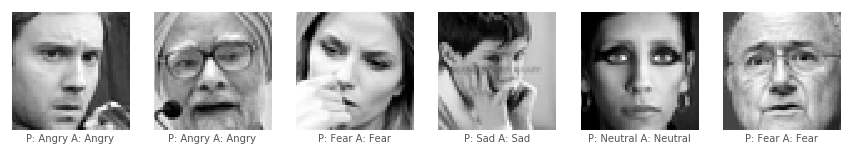

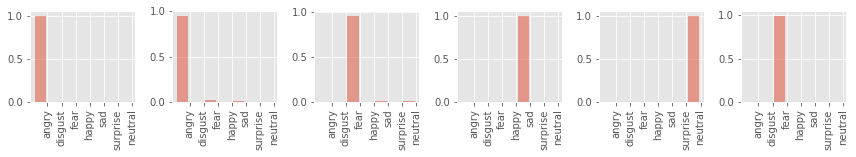

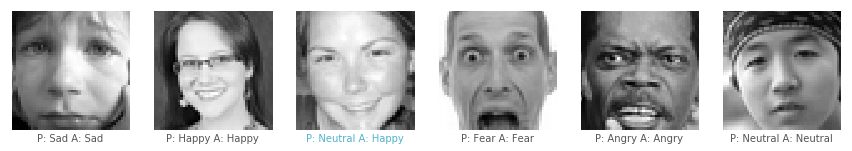

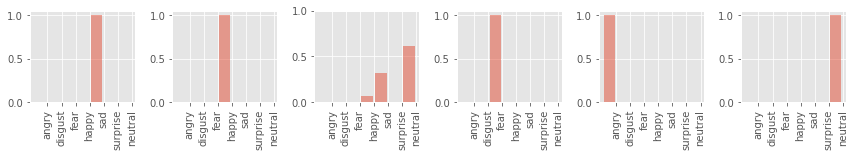

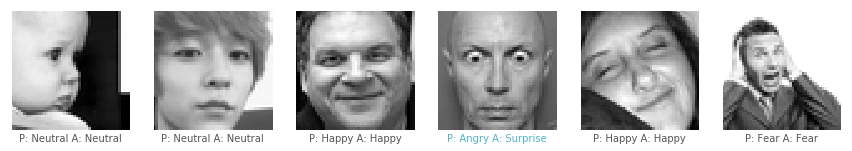

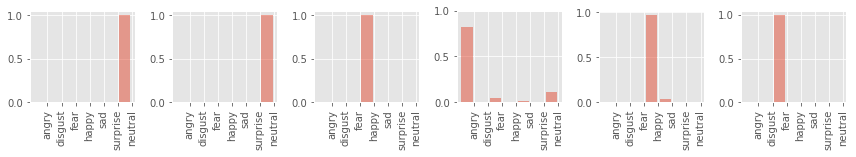

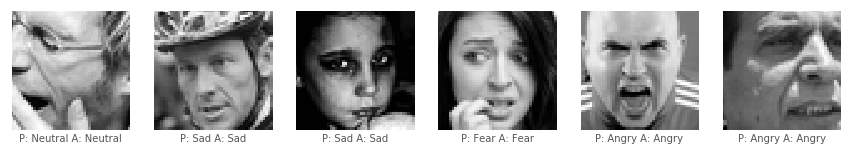

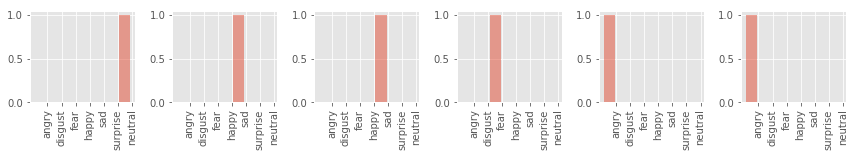

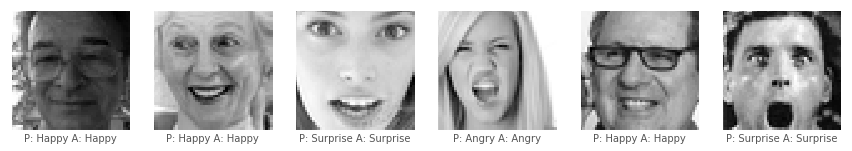

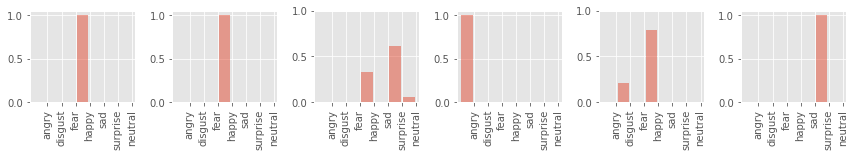

In [122]:
plot_subjects_with_probs(0, 36, y_prob)
+

+

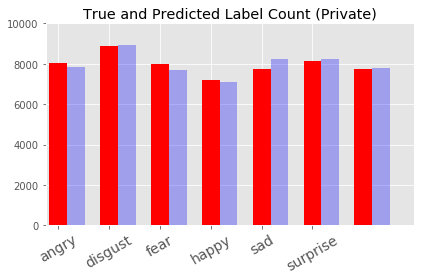

In [124]:
# Plot the distribution of Predicted vs True
labels = ['angry', 'disgust','fear', 'happy', 'sad', 'surprise', 'neutral']
def plot_distribution(y_true, y_pred):
    ind = np.arange(1.5,8,1)  # the x locations for the groups
    width = 0.35   
    fig, ax = plt.subplots()
    true = ax.bar(ind, np.bincount(y_true), width, color='red', alpha=1.0)
    pred = ax.bar(ind + width, np.bincount(y_pred), width, color='blue', alpha=0.3)
    ax.set_xticks(np.arange(1.5,7,1))
    ax.set_xticklabels(labels, rotation=30, fontsize=14)
    ax.set_xlim([1.25, 8.5])
    ax.set_ylim([0, 10000])
    ax.set_title('True and Predicted Label Count (Private)')
    plt.tight_layout()
    plt.show()

plot_distribution(y_true, y_pred)

In [125]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(6,6))
    matplotlib.rcParams.update({'font.size': 16})
    ax  = fig.add_subplot(111)
    matrix = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    fig.colorbar(matrix) 
    for i in range(0,7):
        for j in range(0,7):  
            ax.text(j,i,cm[i,j],va='center', ha='center')
    # ax.set_title('Confusion Matrix')
    ticks = np.arange(len(labels))
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

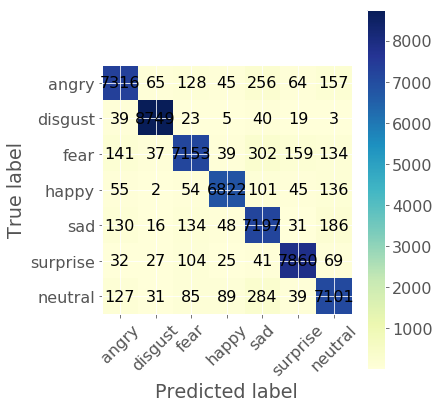

In [126]:
plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.YlGnBu)

In [127]:
# Classification Matrix
def class_precision(y_true, y_pred, emotion):
    cm = confusion_matrix(y_true, y_pred)
    i = [i for i, label in enumerate(labels) if label == emotion][0]
    col = [cm[j,i] for j in range(0,len(labels))]
    return float(col[i])/sum(col)

def class_recall(y_true, y_pred, emotion):
    cm = confusion_matrix(y_true, y_pred)
    i = [i for i, label in enumerate(labels) if label == emotion][0]
    row = [cm[i,j] for j in range(0,len(labels))]
    return float(row[i])/sum(row)

def class_accuracy(y_true, y_pred, emotion):
    cm = confusion_matrix(y_true, y_pred)
    i = [i for i, label in enumerate(labels) if label == emotion][0]
    tp = cm[i,i]
    fn = sum([cm[i,j] for j in range(0,6) if j != i])
    fp = sum([cm[j,i] for j in range(0,6) if j != i])
    tn = sum([cm[i,j] for j in range(0,6) for i in range(0,6)]) -(tp+fp+fn)
    return float(tp + tn)/sum([tp, fn, fp, tn])

In [128]:
# private test set
for emotion in labels:
    print(emotion.upper())
    print('   acc = {}'.format(class_accuracy(y_true, y_pred, emotion)))
    print('  prec = {}'.format(class_precision(y_true, y_pred, emotion)))
    print('recall = {}\n'.format(class_recall(y_true, y_pred, emotion)))

ANGRY
   acc = 0.9798114324370032
  prec = 0.9331632653061225
recall = 0.9109699912837753

DISGUST
   acc = 0.9942288178589549
  prec = 0.9800604906463538
recall = 0.9854697003829691

FEAR
   acc = 0.9763022154574666
  prec = 0.9312589506574664
recall = 0.8980539861895794

HAPPY
   acc = 0.9911423981058685
  prec = 0.9645129365191574
recall = 0.9455301455301456

SAD
   acc = 0.9767672924065618
  prec = 0.8754409439240968
recall = 0.9296047532937226

SURPRISE
   acc = 0.9884364958565872
  prec = 0.9565534866739686
recall = 0.9634714390782054

NEUTRAL
   acc = 0.971672585827837
  prec = 0.9120215771898279
recall = 0.9155492521918515



In [129]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=labels))

              precision    recall  f1-score   support

       angry       0.93      0.91      0.92      8031
     disgust       0.98      0.99      0.98      8878
        fear       0.93      0.90      0.91      7965
       happy       0.96      0.95      0.95      7215
         sad       0.88      0.93      0.90      7742
    surprise       0.96      0.96      0.96      8158
     neutral       0.91      0.92      0.91      7756

   micro avg       0.94      0.94      0.94     55745
   macro avg       0.94      0.94      0.94     55745
weighted avg       0.94      0.94      0.94     55745

